In [1]:
# Task 5: Model Interpretability for Amharic NER

# 1. Import required libraries
import shap
from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import matplotlib.pyplot as plt
import torch
import numpy as np
import json

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu



SHAP explanation:


  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:35, 35.55s/it]                                                                    


<Figure size 640x480 with 0 Axes>


LIME explanation:


TypeError: Object of type ndarray is not JSON serializable

C:\Users\user\miniconda4\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 4851 (\N{ETHIOPIC SYLLABLE DAA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\miniconda4\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 4653 (\N{ETHIOPIC SYLLABLE RE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\miniconda4\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 4720 (\N{ETHIOPIC SYLLABLE TA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\miniconda4\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 4779 (\N{ETHIOPIC SYLLABLE KAA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\miniconda4\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 4725 (\N{ETHIOPIC SYLLABLE TE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\user\miniconda4\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 4727 (\N{ETHIO

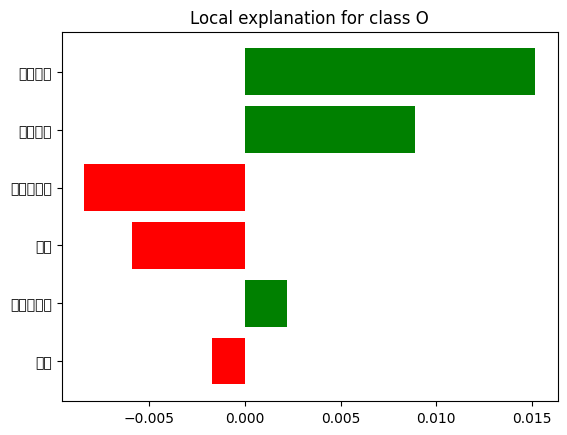

In [2]:
# 2. Load best performing model (replace with your best model path or checkpoint)
best_model_checkpoint = "xlm-roberta-base"  # replace with the best from Task 4
tokenizer = AutoTokenizer.from_pretrained(best_model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(best_model_checkpoint)
nlp = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# 3. Sample text for explanation
sample_text = "ሚኒስትሩ በባህር ዳር ላይ በተደረገ የቴክኖሎጂ ትዕዛዝ ተካትቷል"

# 4. SHAP explanation using custom scoring conversion
print("\nSHAP explanation:")
def wrapped_pipeline(texts):
    results = []
    for text in texts:
        pred = nlp(text)
        label_scores = {}
        for entry in pred:
            label = entry.get("entity_group", "O")
            score = entry.get("score", 0.0)
            if label not in label_scores:
                label_scores[label] = []
            label_scores[label].append(score)
        label_avg_scores = {k: np.mean(v) for k, v in label_scores.items()}
        results.append([label_avg_scores.get(lbl, 0.0) for lbl in ["O", "B-PER", "I-PER", "B-LOC"]])
    return np.array(results)

explainer = shap.Explainer(wrapped_pipeline, shap.maskers.Text(tokenizer))
shap_values = explainer([sample_text])

# Save SHAP plot
plt.figure()
shap.plots.text(shap_values[0])
plt.savefig("../image/shap_explanation_plot.png")
plt.show()  # Optional for Colab/Jupyter
plt.close()

# 5. LIME explanation
print("\nLIME explanation:")
class_names = ["O", "B-PER", "I-PER", "B-LOC"]
lime_explainer = LimeTextExplainer(class_names=class_names)

# Define prediction function for LIME
def predict_proba(texts):
    logits = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            output = model(**inputs).logits
        logits.append(output[0].mean(dim=0).numpy())
    return np.array(logits)

lime_exp = lime_explainer.explain_instance(sample_text, predict_proba, num_features=6, labels=[0])
lime_fig = lime_exp.as_pyplot_figure(label=0)

# 6. Generate JSON Report and Save Plots
report = {
    "text": sample_text,
    "shap_tokens": shap_values.data[0],
    "shap_scores": shap_values.values[0].tolist(),
    "lime_features": lime_exp.as_list(label=0)
}

with open("../data1/ner_model_interpretability_report.json", "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)

lime_fig.savefig("../image/lime_explanation_plot.png")
plt.close(lime_fig)

print("\nReport and plots saved: ner_model_interpretability_report.json, lime_explanation_plot.png, shap_explanation_plot.png")
